# Demo: NLQ

In this notebook, we will explore Nested Lattice Quantization (NLQ) using the `nlq` module. NLQ is a powerful technique for compressing high-dimensional data while preserving its structure.

In [1]:
import sys
sys.path.append('../../')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gemvq.quantizers.nlq import NLQ as NLQ
from gemvq.quantizers.utils import get_d4, closest_point_Dn, SIG_D4

Sanity check: quantize and dequantize a random vector

In [2]:
np.random.seed(31)
q = 4
quantizer = NLQ.create_d4_quantizer(q)

x = np.random.randn(4)
x = x/np.sqrt(np.linalg.norm(x))
print("Original vector:", x)


x_q = quantizer.quantize(x)
print("Quantized vector:", x_q)

enc, T = quantizer.encode(x)
x_dq = quantizer.decode(enc, T)
print("encoded:", enc)
print("overloading factor:", T)
print("Quantized vector:", x_dq)

Original vector: [-0.14882851 -0.51960484 -0.52908427  1.25909143]
Quantized vector: [ 0.  0. -1.  1.]
encoded: [0 0 0 3]
overloading factor: 0
Quantized vector: [ 0.  0. -1.  1.]


Let us try E2 lattice, check out its generator matrix, codebooks, and try to quantize and dequantize a random vector, and try to match the results from the implementation in `gemvq.lattice.nlq`.

In [3]:
from gemvq.quantizers.utils import get_z2, closest_point_Dn

# generator for E2
G = get_z2()

print("Generator matrix for E2 lattice:\n", G)
Ginv = np.linalg.inv(G)

print("Inverse Generator matrix for E2 lattice:\n", Ginv)

def check_z2_codebooks(q):
    quantizer = NLQ.create_z2_quantizer(q)        
    
    # codebook for this lattice, for given q
    codebook = quantizer.create_codebook()

    # Notice that there are q^2  codewords in the lattice
    print("Expected Number of codewords in the codebook:", q**2, 'actual:', len(codebook))

    # we should be able encode the lattice points back to the codewords
    for key, value in codebook.items():
        key_int = tuple(int(k) for k in key)
        enc = np.mod(np.dot(Ginv, value),q)
        print('lattice point', value, 'code', key_int, 'encoded as', tuple(int(e) for e in enc))  

q = [2,3,4]
for qi in q:
    print(f"Checking codebooks for E2 lattice for q={qi}")
    check_z2_codebooks(qi)



Generator matrix for E2 lattice:
 [[1 0]
 [0 1]]
Inverse Generator matrix for E2 lattice:
 [[1. 0.]
 [0. 1.]]
Checking codebooks for E2 lattice for q=2
Expected Number of codewords in the codebook: 4 actual: 4
lattice point [0. 0.] code (0, 0) encoded as (0, 0)
lattice point [ 0. -1.] code (0, 1) encoded as (0, 1)
lattice point [-1.  0.] code (1, 0) encoded as (1, 0)
lattice point [-1. -1.] code (1, 1) encoded as (1, 1)
Checking codebooks for E2 lattice for q=3
Expected Number of codewords in the codebook: 9 actual: 9
lattice point [0. 0.] code (0, 0) encoded as (0, 0)
lattice point [0. 1.] code (0, 1) encoded as (0, 1)
lattice point [ 0. -1.] code (0, 2) encoded as (0, 2)
lattice point [1. 0.] code (1, 0) encoded as (1, 0)
lattice point [1. 1.] code (1, 1) encoded as (1, 1)
lattice point [ 1. -1.] code (1, 2) encoded as (1, 2)
lattice point [-1.  0.] code (2, 0) encoded as (2, 0)
lattice point [-1.  1.] code (2, 1) encoded as (2, 1)
lattice point [-1. -1.] code (2, 2) encoded as (2, 2


**Background**. 


E2 (square lattice) with standard basis

**Setup.** 

Let $L=\mathbb{Z}^2$, $V_L=[-\tfrac{1}{2},\tfrac{1}{2})^2$, and $A_q = L \cap (q V_L)$.


Codebook for $q=2$

$$
A_2 \;=\; \mathbb{Z}^2 \cap [-1,1)^2
\;=\; \{(-1,-1),\,(-1,0),\,(0,-1),\,(0,0)\}.
$$
- Size: $4$ (rate $R=\log_2 2 = 1$ bit/dim)
- Note: even $q$ → boundary points exist; use a consistent half-open convention or fixed dither.



Codebook for $q=3$

$$
A_3 \;=\; \mathbb{Z}^2 \cap \big[-\tfrac{3}{2},\tfrac{3}{2}\big)^2
\;=\; \{-1,0,1\}^2
$$

Explicitly:

$$
\{(-1,-1),(-1,0),(-1,1),(0,-1),(0,0),(0,1),(1,-1),(1,0),(1,1)\}.
$$
- Size: $9$ (rate $R=\log_2 3 \approx 1.585$ bits/dim)
- No boundary ambiguity with the half-open cell.


**Observations**.

For the E2 lattice, the corners of the $A_q$ have magnitude $\pm \frac{q-  (q\mod 2)}{2}$ and
for $\lambda \in A_q, ||\lambda|| \leq q r_{cov}(L) = \frac{q}{\sqrt{2}}$

**Implications**.

when the norm of the input vector is greater than $\frac{q}{\sqrt{2}}$, the quantization error increases significantly. This is because the input vector is being mapped to a lattice point that is far away from it, resulting in a larger quantization error. This is where overload detector has to be triggered. It will downscale the input vector to bring it within the optimal range.

Likewise, when the magnitude of the input vector is substantially less than $\frac{q}{\sqrt{2}}$, some of the input vectors will be mapped to the same lattice point, increasing the quantization error. 

So, the optimal range for the input vector has to be around  $\frac{q}{\sqrt{2}}$. 

**Test** 

Let us test this hypothesis by encoding and decoding input vectors with different magnitudes and observing the quantization error.

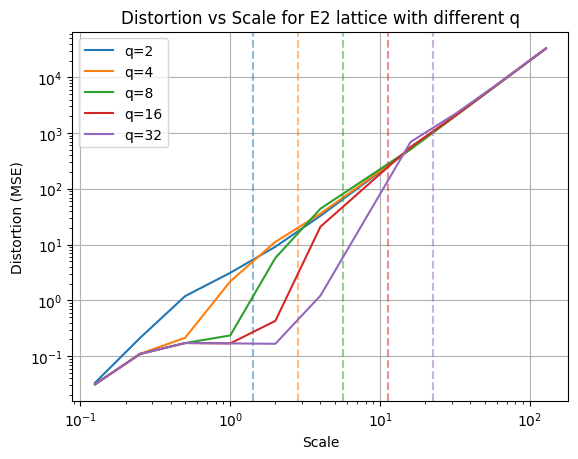

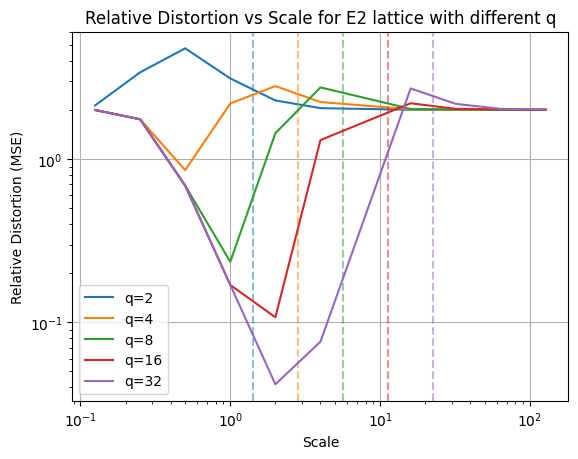

In [47]:
def run_norm_experiments(q,scale,overload, colors,beta,alpha, normalize,relative_distortion=True):
    results = np.zeros((len(q), len(scale))) # distortion, rate
    results_rel = np.zeros((len(q), len(scale))) # distortion, rate
    x_prenorm = np.random.randn(1000,2)
    if normalize:
        x_prenorm = x_prenorm/np.sqrt(np.linalg.norm(x_prenorm, axis=1, keepdims=True))
        #x_prenorm = x_prenorm/np.sqrt(2) # average norm is sqrt(2)
    for i, qi in enumerate(q):
        quantizer = NLQ.create_z2_quantizer(qi, overload=overload,beta=beta,alpha=alpha)        
        for j, si in enumerate(scale):
            x = x_prenorm*si
            # do batch encoding
            b_enc, b_T = quantizer.batch_encode(x)
            # do batch decoding
            x_q = quantizer.batch_decode(b_enc, b_T)
            # compute distortion and rate
            distortion = np.mean(np.linalg.norm(x-x_q, axis=1)**2)
            results[i,j] = distortion
            results_rel[i,j] = distortion/(si**2)
    for i, qi in enumerate(q):
        plt.plot(scale, results[i,:], label=f'q={qi}', color=colors[qi])
        plt.axvline(qi/np.sqrt(2), color=colors[qi], linestyle='--', alpha=0.5)
    
    plt.ylabel('Distortion (MSE)')
    plt.xlabel('Scale')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Distortion vs Scale for E2 lattice with different q')
    plt.legend()
    plt.grid()
    plt.show()

    for i, qi in enumerate(q):
        plt.plot(scale, results_rel[i,:], label=f'q={qi}', color=colors[qi])
        plt.axvline(qi/np.sqrt(2), color=colors[qi], linestyle='--', alpha=0.5)
    
    plt.ylabel('Relative Distortion (MSE)')
    plt.xlabel('Scale')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Relative Distortion vs Scale for E2 lattice with different q')
    plt.legend()
    plt.grid()
    plt.show()


q = [2,4,8,16,32]
colors = {2: 'tab:blue', 4: 'tab:orange', 8: 'tab:green', 16: 'tab:red', 32: 'tab:purple'}
scale = [0.125,0.25,0.5,1,2,4,16,32,64,128]
overload = False
beta = 1
alpha = 1
normalize = False
run_norm_experiments(q,scale,overload,colors,beta,alpha, normalize)



The norm vs distortion exhibits a hockey stick pattern, and the relative distortion vs norm exhibits a bathtub pattern. When the alphabet is large (say 256 for q=8) and if the input norm is small, codebooks are utilised well and relative distortion decreases. The bathtub is apparent at q=8, 16 and 32. 

If the norm of the input is greater than $\frac{q}{\sqrt{2}}$, distortion increases significantly. . Notice that, for all q, the distortion and relative distortion converge beyond certain input norm. The overload error is both dominant and similar for all q in this regime.

Let us re-run the above with overload detector enabled. We should see that the distortion is low even when the input norm is high.

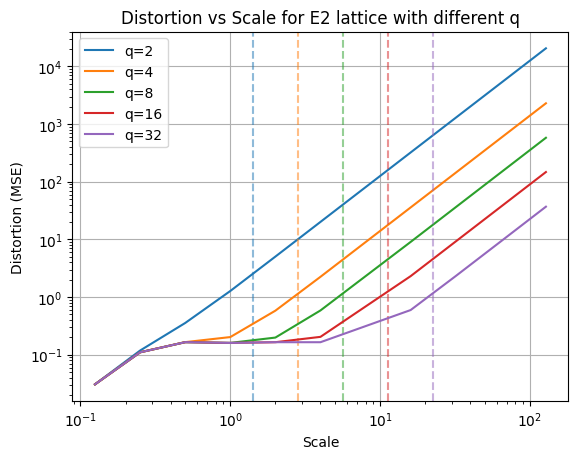

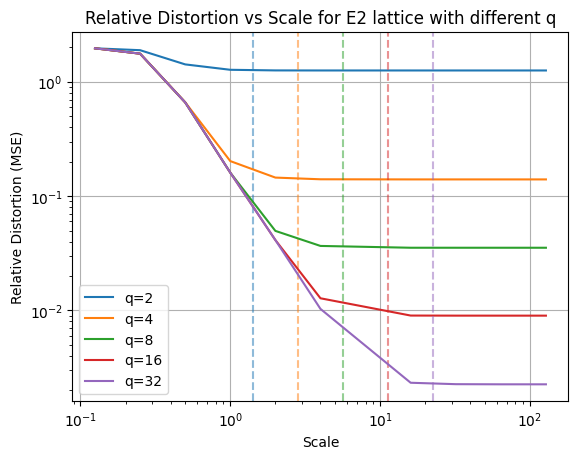

In [48]:
q = [2,4,8,16,32]
colors = {2: 'tab:blue', 4: 'tab:orange', 8: 'tab:green', 16: 'tab:red', 32: 'tab:purple'}
scale = [0.125,0.25,0.5,1,2,4,16,32,64,128]
beta = 1
overload = True
alpha = 1
normalize = False
run_norm_experiments(q,scale,overload,colors,beta,alpha, normalize)

We see a hockey stick pattern for each $q$ here as well except that distortion decreases with increasing q. In other words, as the input norm increase, larger codebooks can accommodate the dynamic range better, and delaying the onset of overloading.  Once the quantizer is overloaded, the distortion increases with increasing input norm, but relative distortion remains constant.

 The distortion is composed of two components: (1) quantization error and (2) overload error. When the input norm is below $\frac{q}{\sqrt{2}}$, the overload error is zero and the distortion is dominated by the quantization error. With pre-scaling and post-scaling, the relative distortion is $\propto scale^{-2}$ and therefore decreases with increasing input norm. But once the input norm exceeds $\frac{q}{\sqrt{2}}$, the relative distortion flattens out as the quantization error now scaling term determining the overload factor.

**Take Away**
Keep the norm of the input below critical value by rescaling. Use overload detector to trigger rescaling when the input norm exceeds the critical value.

Let us see if this is true for D4 lattice as well.

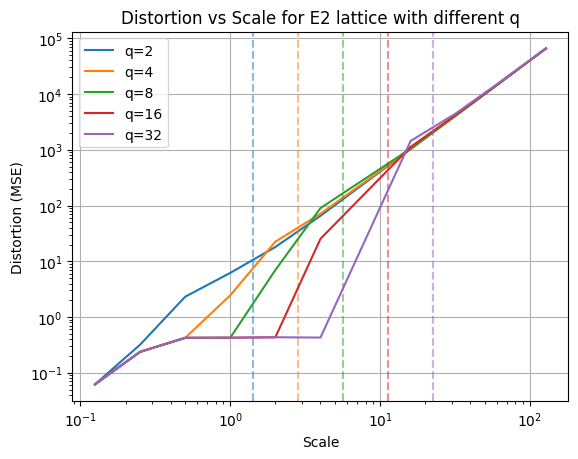

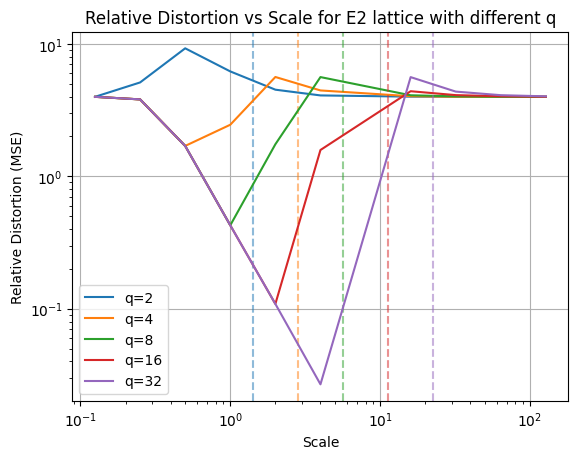

In [ ]:
def run_norm_experiments_d4(q,scale,overload, colors,beta,alpha, normalize,relative_distortion=True):
    results = np.zeros((len(q), len(scale))) # distortion, rate
    results_rel = np.zeros((len(q), len(scale))) # distortion, rate
    x_prenorm = np.random.randn(1000,4)
    if normalize:
        x_prenorm = x_prenorm/np.sqrt(np.linalg.norm(x_prenorm, axis=1, keepdims=True))
        #x_prenorm = x_prenorm/np.sqrt(2) # average norm is sqrt(2)
    for i, qi in enumerate(q):
        quantizer = NLQ.create_d4_quantizer(qi, overload=overload,beta=beta,alpha=alpha)        
        for j, si in enumerate(scale):
            x = x_prenorm*si
            # do batch encoding
            b_enc, b_T = quantizer.batch_encode(x)
            # do batch decoding
            x_q = quantizer.batch_decode(b_enc, b_T)
            # compute distortion and rate
            distortion = np.mean(np.linalg.norm(x-x_q, axis=1)**2)
            results[i,j] = distortion
            results_rel[i,j] = distortion/(si**2)
    for i, qi in enumerate(q):
        plt.plot(scale, results[i,:], label=f'q={qi}', color=colors[qi])
        plt.axvline(qi/np.sqrt(2), color=colors[qi], linestyle='--', alpha=0.5)
    
    plt.ylabel('Distortion (MSE)')
    plt.xlabel('Scale')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Distortion vs Scale for D4 lattice with different q')
    plt.legend()
    plt.grid()
    plt.show()

    for i, qi in enumerate(q):
        plt.plot(scale, results_rel[i,:], label=f'q={qi}', color=colors[qi])
        plt.axvline(qi/np.sqrt(2), color=colors[qi], linestyle='--', alpha=0.5)
    
    plt.ylabel('Relative Distortion (MSE)')
    plt.xlabel('Scale')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Relative Distortion vs Scale for D4 lattice with different q')
    plt.legend()
    plt.grid()
    plt.show()


q = [2,4,8,16,32]
colors = {2: 'tab:blue', 4: 'tab:orange', 8: 'tab:green', 16: 'tab:red', 32: 'tab:purple'}
scale = [0.125,0.25,0.5,1,2,4,16,32,64,128]
overload = False
beta = 1
alpha = 1
normalize = False
run_norm_experiments_d4(q,scale,overload,colors,beta,alpha, normalize)

Indeed, we see the same pattern for D4 lattice as well. The critical value for D4 lattice is $\frac{q}{\sqrt{2}}$ as well. Let us see the behavior with overload detector enabled.

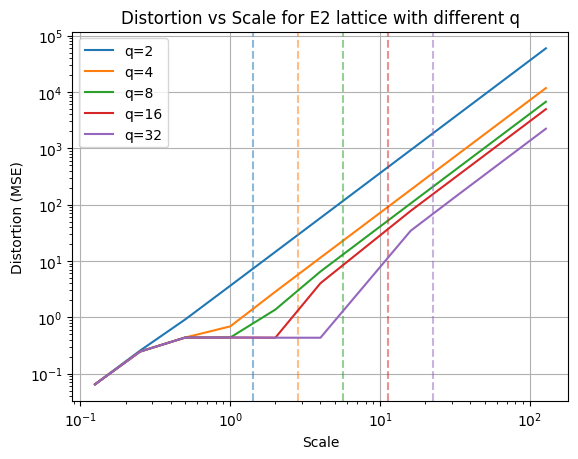

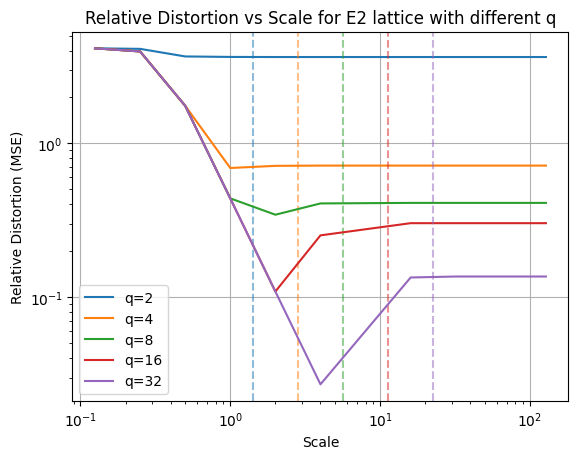

In [51]:
run_norm_experiments_d4(q,scale,True,colors,beta,alpha, normalize)

It is similar to E2 lattice. The distortion decreases with increasing q, and the relative distortion flattens out once the quantizer is overloaded. But the transition is not very smooth. This is because the overload detector is not very accurate for D4 lattice. It is based on a bounding sphere, which is not a very tight fit for D4 lattice. A better overload detector can be designed based on the Voronoi cell of the lattice.

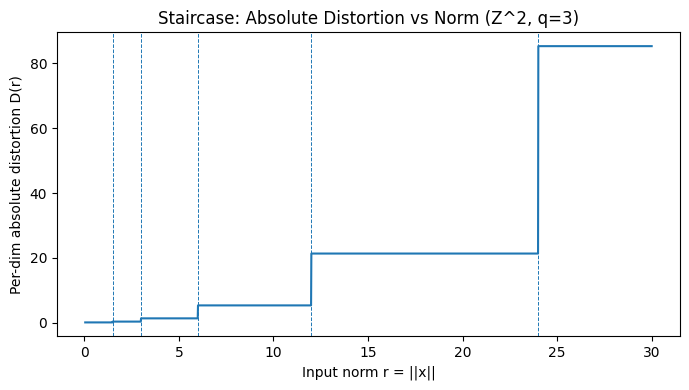

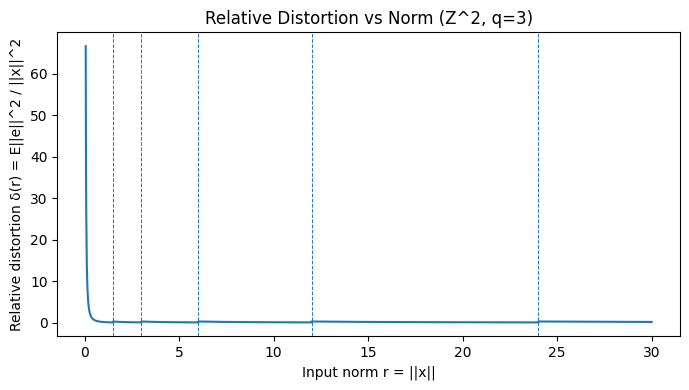

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Z^2
d = 2
sigma2 = 1.0/12.0  # per-dimension second moment of Z^2
q = 3
beta0 = 1.0
R_in = 0.5  # inradius for Z^2
tau = beta0 * q * R_in  # capture threshold

# Range of norms
r = np.linspace(0.05, 30.0, 2000)

# Overload-avoidance T(r) and distortions
def T_of_r(rr, tau):
    a = np.log2(np.maximum(rr, 1e-12)/tau)
    return np.ceil(np.maximum(0.0, a)).astype(int)

T = T_of_r(r, tau)
beta = beta0 * (2.0**T)

# Absolute distortion per dimension (granular, with no-overload guarantee)
D = (beta**2) * sigma2

# Relative distortion (with subtractive dither; expected)
delta = (d * (beta**2) * sigma2) / (r**2)

# Plot 1: Absolute distortion (staircase)
plt.figure(figsize=(7,4))
plt.plot(r, D)
# Threshold markers where T increments (optional visual aids)
# increments at r = tau * 2^k for k >= 0
k_vals = np.arange(0, 10)
thresholds = tau * (2.0**k_vals)
thresholds = thresholds[thresholds <= r.max()]
for th in thresholds:
    plt.axvline(th, linestyle="--", linewidth=0.7)
plt.xlabel("Input norm r = ||x||")
plt.ylabel("Per-dim absolute distortion D(r)")
plt.title("Staircase: Absolute Distortion vs Norm (Z^2, q=3)")
plt.tight_layout()
plt.show()

# Plot 2: Relative distortion (decrease within plateaus, jumps at thresholds)
plt.figure(figsize=(7,4))
plt.plot(r, delta)
for th in thresholds:
    plt.axvline(th, linestyle="--", linewidth=0.7)
plt.xlabel("Input norm r = ||x||")
plt.ylabel("Relative distortion δ(r) = E||e||^2 / ||x||^2")
plt.title("Relative Distortion vs Norm (Z^2, q=3)")
plt.tight_layout()
plt.show()